# Song and Artist Embeddings Experiments

## Andy Ham & Jay Dhanoa (aham-jdhanoa)

## Song Embeddings
### (a)

In [1]:
from pyspark.sql import SparkSession
import re
import operator
import numpy as np
import math
import string
import nltk
from collections import Counter
from pprint import pprint

spark  = SparkSession.builder.master('local[28]').appName('song_embeddings')\
.getOrCreate()

def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and punctuation to whitespace
    s = s.encode('utf-8').lower().replace('-',' ').translate(None, string.punctuation)
    # replace \r\n
    s = re.sub(r'(\r\n )+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    return s.split(' ')

vectors_file = 'song-vectors.txt'

with open('/project/cmsc25025/playlist/song_hash.txt', 'r') as fh:
    words = [re.split(r'\t+', x.rstrip())[1] for x in fh.readlines()]
#9774 songs. format is index song_name artist

songvocab = {w: idx for idx, w in enumerate(words)}
isongvocab = {idx: w for idx, w in enumerate(words)}

#9766 in song-vectors.txt including '<unk>'
with open(vectors_file, 'r') as fh:
    song_vectors = {}
    for line in fh:
        vals = line.rstrip().split(' ')
        if vals[0] != '<unk>':
            if int(vals[0]) <= 9774:
                name = isongvocab[int(vals[0])]
                song_vectors[name] = [float(x) for x in vals[1:]] 
            else: 
                song_vectors[int(vals[0])] = [float(x) for x in vals[1:]] 
        else:
            song_vectors[vals[0]] = [float(x) for x in vals[1:]]

isong_to_tagvec = {}
isong_to_tags = {}
with open('/project/cmsc25025/playlist/song-to-tags.txt','r') as fh:
    for line in fh:
        song_id, tag_ids = line.rstrip().split()
        song_id = int(song_id)
        tag_values = tag_ids.split(',')
        if tag_values[0] != '#':
            tag_id_list = map(int,tag_values)
            tag_values = set(tag_id_list)
        else:
            tag_values = set()
            tag_id_list = []
        
        tag_vector = [0]*250
        for x in range(250):
            if x in tag_values:
                tag_vector[x]=1
        isong_to_tagvec[song_id] = tag_vector
        isong_to_tags[song_id] = tag_id_list

tag_list = []
with open('/project/cmsc25025/playlist/tag_hash.txt','r') as fh:
    for line in fh:
        tag_id, tag = line.rstrip().split(', ')
        tag_list.append(tag)

## KMeans Clustering

In [2]:
from pyspark.mllib.clustering import KMeans
from collections import Counter
import random
from pprint import pprint

def flatten(list_of_lists):
    return [val for sublist in list_of_lists for val in sublist]

kmeans_vec = [(x, song_vectors[x]) for x in song_vectors]
df = spark.sparkContext.parallelize(kmeans_vec)
model = KMeans.train(df.map(lambda x: x[1]), 5, maxIterations=1000, initializationMode="random")
cluster_labels = df.map(lambda x: (model.predict(x[1]),x[0])).groupByKey().mapValues(list)
cluster_features = df.map(lambda x: (model.predict(x[1]),x[1])).groupByKey().mapValues(list)

major_labels = dict(cluster_labels.map(lambda x: (x[0], Counter(x[1]).most_common(1)[0][0])).collect())

# songs clustered by tags
labels = cluster_labels.collect()

for i, songlist in labels:
    songlist = filter(lambda x: x!='<unk>', songlist)
    testresult = map(lambda x: songvocab[x],songlist)
    song_tags = flatten(map(lambda x: isong_to_tags[songvocab[x]],songlist))
    song_tags = map(lambda x: tag_list[x], song_tags)
    ct = Counter(song_tags)
    print("TOP 5 TAGS FOR CLUSTER {}:\n".format(i+1))
    print("{:<3}{:<20}{:<5}".format("","Tag","Count"))
    print("-"*28)
    for i, x in enumerate(ct.most_common(5)):
        print("{:<3}{:<20}{:<5}".format(str(i+1)+":", x[0],x[1]))
    print("\n")

TOP 5 TAGS FOR CLUSTER 1:

   Tag                 Count
----------------------------
1: rock                2385 
2: pop                 2197 
3: favorites           2092 
4: male vocalists      1686 
5: love                1553 


TOP 5 TAGS FOR CLUSTER 2:

   Tag                 Count
----------------------------
1: pop                 362  
2: favorites           306  
3: love                297  
4: rock                282  
5: american            230  


TOP 5 TAGS FOR CLUSTER 3:

   Tag                 Count
----------------------------
1: pop                 103  
2: dance               87   
3: hip-hop             80   
4: rnb                 76   
5: hip hop             70   


TOP 5 TAGS FOR CLUSTER 4:

   Tag                 Count
----------------------------
1: rock                471  
2: favorites           423  
3: pop                 371  
4: alternative         331  
5: male vocalists      326  


TOP 5 TAGS FOR CLUSTER 5:

   Tag                 Count
----------------

Generally (albeit sometimes in different orders), we have the following categories:
* Rock/Pop Rock
* Alternative rock
* Country
* Rhythym N' Blues Pop (e.g. stuff by Bruno Mars)
* Pop/Rock (e.g. Coldplay)

## t-SNE visualization

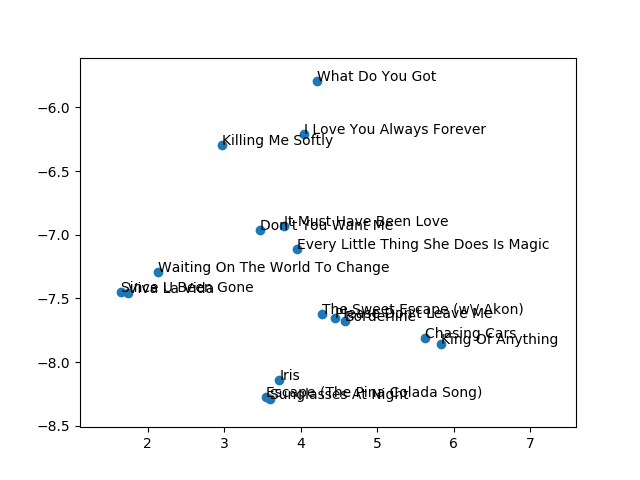

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
import sys  

def plot_songs():
    reload(sys)  
    sys.setdefaultencoding('utf8')
    #W contains embeding vectors as rows
    # words contains the word labels in the same order as the rows of W

    words = song_vectors.keys()
    W = song_vectors.values() 


    tsne = TSNE(n_components=2, random_state = 0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(W[:1000])

    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext = (0, 0),
            textcoords='offset points')

    plt.show()

from IPython.display import Image
Image(filename='songs.png')

Window: X=[2,8], Y=[-5.5,-9]

This is a cluster of pop songs.

A list of songs that I could read (in order from top to bottom):
* What Do You Got
* I Love You Always Forever
* Killing Me Softly
* It Must Have Been Love
* Don't You Want Me
* Every Little Thing She Does is Magic
* Waiting on the World to Change
* Since U Been Gone
* Viva La Vida
* The Sweet Escape (w/ Akon)
* Chasing Cars
* King of Anything
* Iris
* The Pina Colada Song

Interestingly, the more recent songs are clustered towards the bottom.

The only real outlier here is "What Do You Got" (Bon Jovi), which is pop rock, as opposed to regular pop.

For the most part, the songs are relatively laid back, with the exception of Bon Jovi's "What Do You Got" and Kelly Clarkson's "Since U Been Gone".

## Artist Clustering

In [4]:
import re
import numpy as np
vectors_file = 'artist-vectors.txt'

with open('/project/cmsc25025/playlist/artist_hash.txt', 'r') as f:
    words = [re.split(r'\t+', x.rstrip())[1] for x in f.readlines()]
#3222 artists

artistvocab = {w: idx for idx, w in enumerate(words)}
iartistvocab = {idx: w for idx, w in enumerate(words)}

with open(vectors_file, 'r') as fh:
    vectors_artist = {}
    for line in fh:
        vals = line.rstrip().split(' ')
        if vals[0] != '<unk>':
            if int(vals[0]) < 3223:
                name = iartistvocab[int(vals[0])]
                vectors_artist[name] = np.array([float(x) for x in vals[1:]] )
            else: 
                vectors_artist[int(vals[0])] = np.array([float(x) for x in vals[1:]] )
        else:
            vectors_artist[vals[0]] = np.array([float(x) for x in vals[1:]])

3222 artists recognized in artist_hash.txt, but in the vectors file we have 3293 entries. so our final dictionary vectors_artists{} can have 3222 artists defined as keys, but for the 70 extra ones that are not defined plus the weird '<unk>' song id, they are preserved as keys in their original state 

In [5]:
def most_similar_word(input_val, vector_dict, topn=5, input_is_vector=False):
    result = []
    if input_is_vector:
        input_vector = input_val
    else:
        input_vector = vector_dict[input_val]
    list_of_keys = vector_dict.keys()
    result = [(i, np.linalg.norm(input_vector-vector_dict[i])) for i in list_of_keys]
    result = sorted(result, key=lambda x: x[1])
    return result[1:topn+1]

def most_similar_artist(artist):
    result_list = most_similar_word(artist, vectors_artist)
    print("{}".format(artist))
    print("-"*25)
    for i, x in enumerate(result_list):
        print("{:<3}{:<20}".format(i+1,x[0]))
    print("\n")

most_similar_artist("The Beatles")
most_similar_artist("The Red Hot Chili Peppers")
most_similar_artist("Usher")

The Beatles
-------------------------
1  Creedence Clearwater Revival
2  The Kinks           
3  The Electric Light Orchestra
4  America             
5  Grand Funk Railroad 


The Red Hot Chili Peppers
-------------------------
1  Stone Temple Pilots 
2  Pearl Jam           
3  Nirvana             
4  Sublime             
5  Bush                


Usher
-------------------------
1  B.o.B               
2  Far East Movement   
3  Flo-Rida            
4  B.o.B.              
5  Jay Sean            




These results seem pretty good. A quick youtube search for 'Creedence Clearwater Revival' and listening to 'Have you ever seen the rain' yields a song that sounds *remarkably* like the Beatles. ELO is also a contemporary of the Beatles (and are also pretty good).

Red Hot Chili Peppers were around the same era as Nirvana. Some quick sampling of songs on youtube from Sublime and the other artists yield similar results. Nirvana and Stone Temple Pilots are generally more rock-heavy, but some of their songs (e.g. "All Apologies" by Nirvana) have non-rock parts that sound similar to Red Hot Chili Peppers & Sublime.

Usher does pop music like B.o.B, Flo-Rida, and Far East Movement. All are contemporary electronic pop artists that make heavy use of synths & voice modulation. All are also disliked by Jay's dad, who listens a lot to songs from the Beatles' group of artists. Seems good.

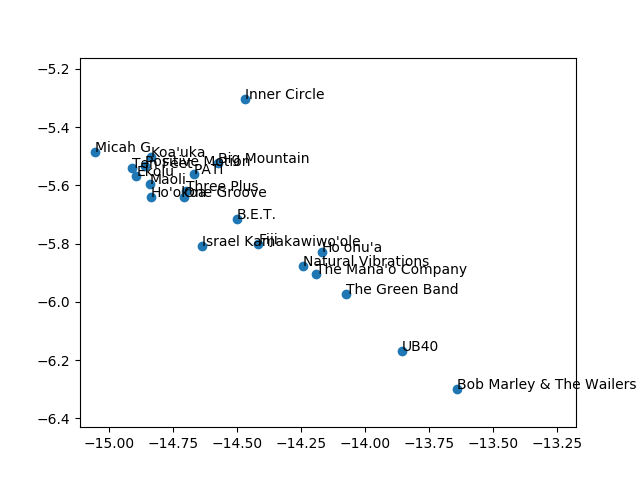

In [6]:
def plot_songs2():
    reload(sys)  
    sys.setdefaultencoding('utf8')
    #W contains embeding vectors as rows
    # words contains the word labels in the same order as the rows of W

    words = vectors_artist.keys()
    W = vectors_artist.values() 

    #words, W = zip(*vectors.items())



    tsne = TSNE(n_components=2, random_state = 0)
    np.set_printoptions(suppress=True)
    #Y = tsne.fit_transform(W[:1000,:])
    Y = tsne.fit_transform(W[:3000])

    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext = (0, 0),
            textcoords='offset points')

    plt.show()

Image(filename='songs2.png') 

This cluster contains a lot of artists and bands from the pacific islands, or at the very least coastal locations with similar chill, relaxing, reggae music. Glad to see my personal favorite, Israel Kamakawiwo'ole AKA "Iz." If you haven't had the chance, check out his cover of Somewhere Over the Rainbow!   